In [8]:
# Setup: install packages (usually preinstalled in Colab) and make images directory
import os
!pip install --quiet numpy matplotlib
os.makedirs("images", exist_ok=True)
print("images/ folder ready. Generated images will be saved there.")


images/ folder ready. Generated images will be saved there.


In [9]:
# Gridworld value iteration (4 reward cases) and save heatmaps
import numpy as np
import matplotlib.pyplot as plt
GAMMA = 0.9
ACTIONS = ['U','D','L','R']

def transition(state, action):
    i,j = state
    if action == 'U': return (i-1, j)
    if action == 'D': return (i+1, j)
    if action == 'L': return (i, j-1)
    if action == 'R': return (i, j+1)

def valid(s):
    i,j = s
    # blocked cell (1,1) is wall as in classic setup
    return 0 <= i < 3 and 0 <= j < 4 and not (i == 1 and j == 1)

def clip(s):
    return s if valid(s) else None

def rwd(s, r):
    if s == (1,3): return -1
    if s == (2,3): return 1
    return r

def compute_value(r, gamma=GAMMA, theta=1e-4):
    V = np.zeros((3,4))
    V[1,3] = -1
    V[2,3] = 1
    while True:
        delta = 0
        old = V.copy()
        for i in range(3):
            for j in range(4):
                if (i,j) in [(1,3),(2,3)]: continue
                if (i,j) == (1,1): continue
                vals = []
                for a in ACTIONS:
                    main = clip(transition((i,j), a))
                    left = {'U':'L','D':'R','L':'D','R':'U'}[a]
                    right = {'U':'R','D':'L','L':'U','R':'D'}[a]
                    left = clip(transition((i,j), left))
                    right = clip(transition((i,j), right))
                    total = 0.0
                    for s2, p in [(main,0.8),(left,0.1),(right,0.1)]:
                        s2 = s2 if s2 else (i,j)
                        total += p * (rwd(s2, r) + gamma * V[s2])
                    vals.append(total)
                V[i,j] = max(vals)
                delta = max(delta, abs(V[i,j] - old[i,j]))
        if delta < theta:
            break
    return V

def plot_and_save(V, filename, title=None):
    plt.figure(figsize=(5,4))
    plt.imshow(V, cmap='viridis', origin='upper')
    plt.colorbar()
    if title is None: title = filename
    plt.title(title)
    plt.savefig(f"images/{filename}.png", bbox_inches='tight', dpi=150)
    plt.close()

# Run 4 reward cases and save images
values = {
    -2: "value_r_minus2",
    0.1: "value_r_0_1",
    0.02: "value_r_0_02",
    1: "value_r_1"
}

for r, name in values.items():
    print(f"Computing for r = {r}")
    V = compute_value(r)
    plot_and_save(V, name, title=f"Gridworld Value (r={r})")

print('Gridworld images saved in images/ folder:')
import os
print(os.listdir('images'))


Computing for r = -2
Computing for r = 0.1
Computing for r = 0.02
Computing for r = 1
Gridworld images saved in images/ folder:
['value_r_0_02.png', 'value_r_1.png', 'value_r_0_1.png', 'value_r_minus2.png']


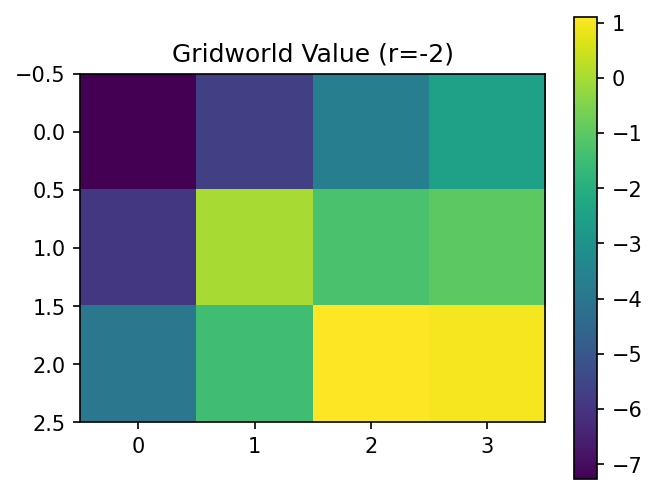

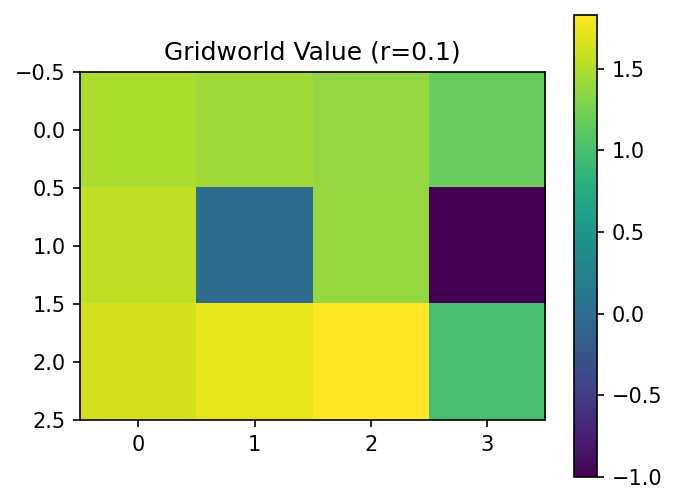

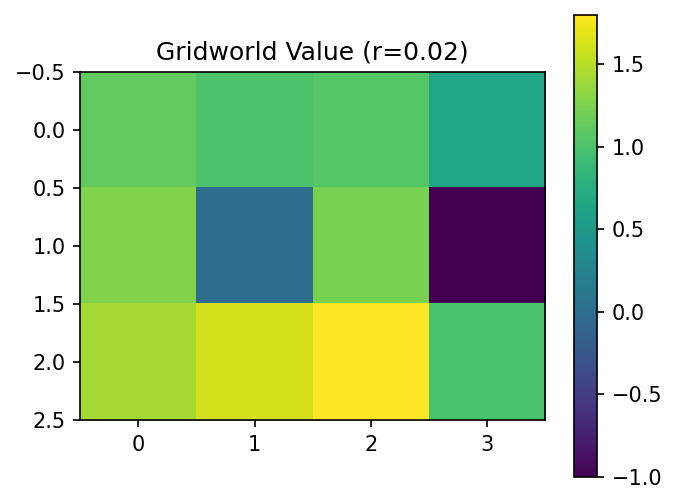

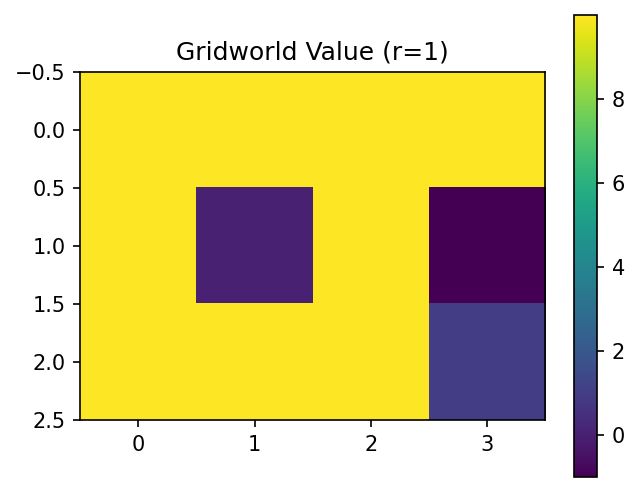

In [10]:
# Display the generated Gridworld images inline
from IPython.display import Image, display
for fn in ["value_r_minus2.png","value_r_0_1.png","value_r_0_02.png","value_r_1.png"]:
    path = f"images/{fn}"
    if os.path.exists(path):
        display(Image(path, width=600))
    else:
        print("Missing:", path)


In [14]:
# Fast (approx) Gbike policy iteration implementation
import numpy as np
import matplotlib.pyplot as plt
from math import exp, factorial

MAX_BIKES = 20
MAX_MOVE = 5
RENT_REWARD = 10
MOVE_COST = 2
GAMMA = 0.9

def poisson(n, lam):
    return (lam**n) * exp(-lam) / factorial(n)

def precompute_poisson(lam, cutoff=11):
    probs = [poisson(i, lam) for i in range(cutoff)]
    probs.append(max(0.0, 1.0 - sum(probs)))
    return np.array(probs)

req1 = precompute_poisson(3)
req2 = precompute_poisson(4)
ret1 = precompute_poisson(3)
ret2 = precompute_poisson(2)

# We'll use global V inside compute_transition for speed in this cell
V = np.zeros((MAX_BIKES+1, MAX_BIKES+1))

def compute_transition_value(i, j, action):
    # i,j are current end-of-day counts (0..20)
    s1 = max(0, min(MAX_BIKES, i - action))
    s2 = max(0, min(MAX_BIKES, j + action))
    expected_reward = -MOVE_COST * abs(action)
    expected_value = 0.0

    # Sum over truncated request/return distributions
    for r1 in range(len(req1)):
        for r2 in range(len(req2)):
            rentals1 = min(r1, s1)
            rentals2 = min(r2, s2)
            prob_r = req1[r1] * req2[r2]
            expected_reward += prob_r * (rentals1 + rentals2) * RENT_REWARD

            s1_after = s1 - rentals1
            s2_after = s2 - rentals2

            for t1 in range(len(ret1)):
                for t2 in range(len(ret2)):
                    prob = prob_r * ret1[t1] * ret2[t2]
                    ns1 = min(MAX_BIKES, s1_after + t1)
                    ns2 = min(MAX_BIKES, s2_after + t2)
                    expected_value += prob * V[ns1, ns2]

    return expected_reward + GAMMA * expected_value

# Policy iteration with limited sweeps for speed
policy = np.zeros((MAX_BIKES+1, MAX_BIKES+1), dtype=int)
for it in range(10):
    # Policy evaluation: do a few sweeps of synchronous update
    for _ in range(3):
        newV = np.zeros_like(V)
        for i in range(MAX_BIKES+1):
            for j in range(MAX_BIKES+1):
                a = policy[i,j]
                newV[i,j] = compute_transition_value(i, j, a)
        V = newV.copy()

    # Policy improvement
    stable = True
    for i in range(MAX_BIKES+1):
        for j in range(MAX_BIKES+1):
            best_val = -1e18
            best_a = policy[i,j]
            for a in range(-MAX_MOVE, MAX_MOVE+1):
                if not (0 <= i - a <= MAX_BIKES and 0 <= j + a <= MAX_BIKES):
                    continue
                val = compute_transition_value(i, j, a)
                if val > best_val:
                    best_val = val
                    best_a = a
            if best_a != policy[i,j]:
                stable = False
            policy[i,j] = best_a
    print(f"Iteration {it+1}: stable={stable}")
    if stable:
        break

# Save images
plt.figure(figsize=(6,5))
plt.imshow(policy, cmap='coolwarm', origin='lower')
plt.colorbar(label='bikes moved (policy)')
plt.title('Gbike Policy (fast approx)')
plt.savefig('images/gbike_policy_fast.png', bbox_inches='tight', dpi=150)
plt.close()

plt.figure(figsize=(6,5))
plt.imshow(V, cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title('Gbike Value function (fast approx)')
plt.savefig('images/gbike_value_fast.png', bbox_inches='tight', dpi=150)
plt.close()

print('Gbike images saved: gbike_policy_fast.png, gbike_value_fast.png')



Iteration 1: stable=False
Iteration 2: stable=False
Iteration 3: stable=False
Iteration 4: stable=False
Iteration 5: stable=False
Iteration 6: stable=False
Iteration 7: stable=False
Iteration 8: stable=True
Gbike images saved: gbike_policy_fast.png, gbike_value_fast.png


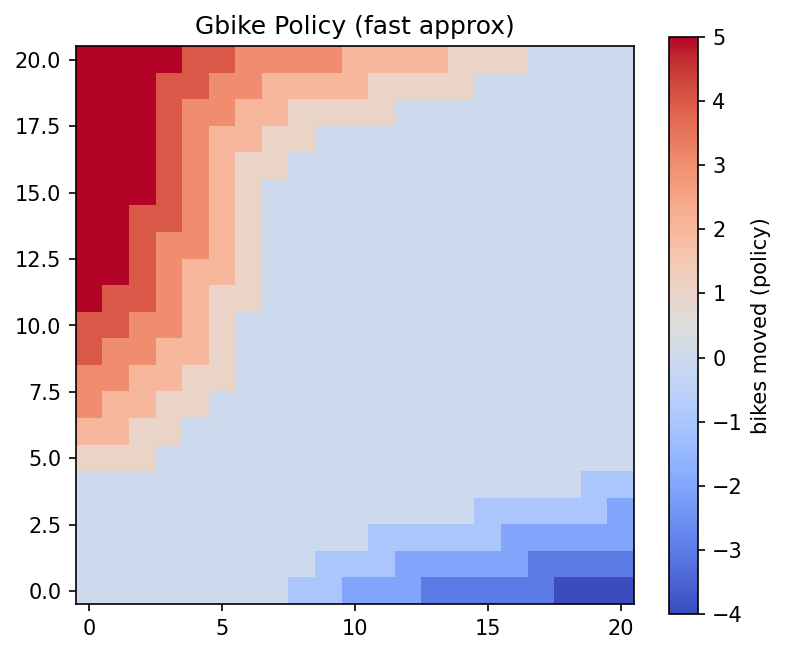

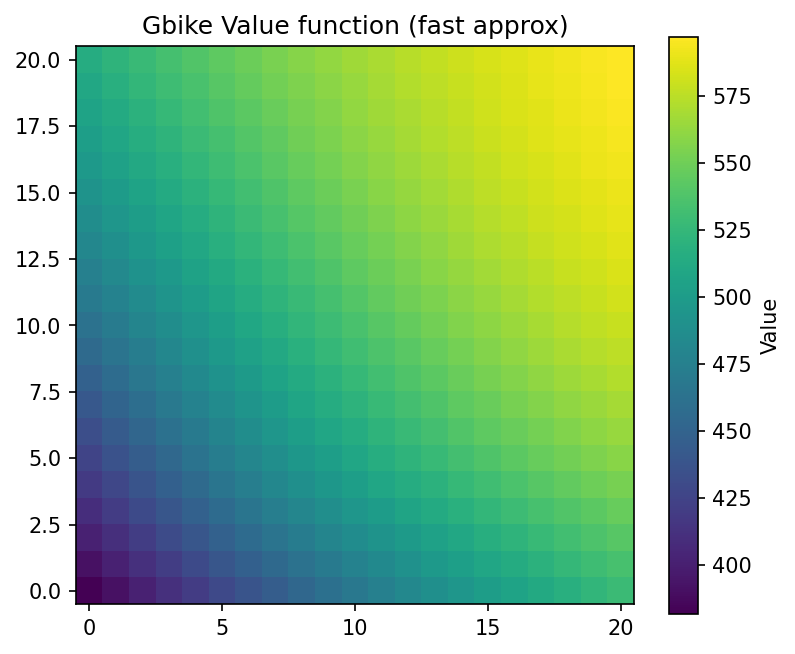

In [15]:
from IPython.display import Image, display
for fn in ['gbike_policy_fast.png','gbike_value_fast.png']:
    path = f'images/{fn}'
    if os.path.exists(path):
        display(Image(path, width=700))
    else:
        print("Missing:", path)
